In [1]:
import gensim.downloader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
from gensim.models import KeyedVectors
from keras.layers import Dense, Flatten, LSTM, GRU, Bidirectional, Embedding
from keras.models import Sequential
from keras.preprocessing import sequence, text
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, classification_report
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('data\preprocessed.csv').dropna()
nlp = spacy.load("en_core_web_sm")
#glove = gensim.downloader.load('glove-twitter-200')
#glove.save("glove.model")
glove = KeyedVectors.load("glove.model")

In [3]:
words = list(glove.key_to_index.keys())
embeddings_index = {}
for word in words:    
    coefs = np.asarray(glove[word], dtype='float32')
    embeddings_index[word] = coefs
print(len(embeddings_index))

1193514


In [4]:
X = data["Reviews_cleaned"]
y = data["Category"]

In [5]:
maxlen = 20
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
print(f"Znaleziono {len(word_index)} unikatowych tokenów.")
data_X = sequence.pad_sequences(sequences, maxlen=maxlen)
print(f"Kształt tensora danych: {data_X.shape}") 
print(f"Kształt tensora etykiet: {y.shape}")

Znaleziono 9691 unikatowych tokenów.
Kształt tensora danych: (40700, 20)
Kształt tensora etykiet: (40700,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(data_X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [8]:
X_train.shape, X_test.shape, X.shape

((32560, 20), (8140, 20), (40700,))

In [9]:
embedding_dim = 200
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Słowa nieznalezione w osadzanym indeksie zostaną zastąpione zerami.
            embedding_matrix[i] = embedding_vector

In [10]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 200)           2000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 128)           135680    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9

In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=6,
                    batch_size=32,
                    validation_split=0.2)
#model.save_weights('pre_trained_glove_model.h5')

Epoch 1/6
814/814 [==============================] - 80s 92ms/step - loss: 0.4771 - acc: 0.7811 - val_loss: 0.4503 - val_acc: 0.8004
Epoch 2/6
814/814 [==============================] - 70s 85ms/step - loss: 0.4456 - acc: 0.7984 - val_loss: 0.4427 - val_acc: 0.8022
Epoch 3/6
814/814 [==============================] - 68s 83ms/step - loss: 0.4338 - acc: 0.8040 - val_loss: 0.4451 - val_acc: 0.8018
Epoch 4/6
814/814 [==============================] - 67s 82ms/step - loss: 0.4242 - acc: 0.8110 - val_loss: 0.4391 - val_acc: 0.8044
Epoch 5/6
814/814 [==============================] - 67s 82ms/step - loss: 0.4118 - acc: 0.8187 - val_loss: 0.4393 - val_acc: 0.8013
Epoch 6/6
814/814 [==============================] - 67s 82ms/step - loss: 0.4009 - acc: 0.8235 - val_loss: 0.4425 - val_acc: 0.8028


In [12]:
y_pred = np.round(model.predict(X_test))
f1_score(y_test, y_pred)

0.8718202841096794

In [13]:
cohen_kappa_score(y_test, y_pred)

0.506804294615381

In [14]:
def plot_history(history, key="loss"):
    metric = history.history[key]
    val_metric = history.history[f"val_{key}"]
    epochs = range(len(metric))
    plt.plot(epochs, metric, "bo", label=f"{key} - train")
    plt.plot(epochs, val_metric, "b", label=f"{key} - val")
    plt.title(f"training - {key}")
    plt.legend()
    plt.show()

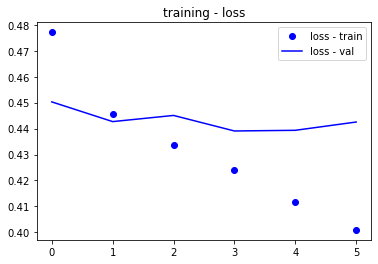

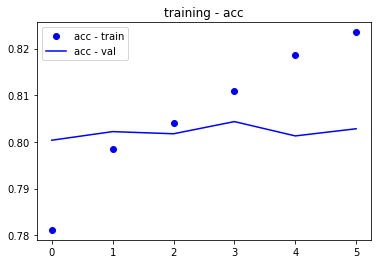

In [19]:
plot_history(history)
plot_history(history, key='acc')